# Introductory Analysis w/ PGR-TK

Adapted code from `pgr-tk.ipynb`, https://github.com/GeneDx/pgr-tk, and https://genedx.github.io/pgr-tk/

`data` directory containing analysis located at `/storage/wwford/pgr-tk-test/data` on snorlax

In this notebook I use PGR-TK to visualize several structurally variable genes listed below.
* C4
* HTT
* CEL
* INS
* PRDM9

## Preprocess Pangenome

### Set up environment

In [1]:
%%bash
#conda install -c bioconda -c conda-forge python_abi libstdcxx-ng=12 libclang13 pgr-tk=0.3.6

In [2]:
from pathlib import Path
import pgrtk, os
print(pgrtk.__version__)

import matplotlib.pyplot as plt

pgrtk 0.3.6 (bioconda release build, linux [x86_64] [rustc 1.69.0 (84c898d65 2023-04-16)])


### Generate pgr-tk database through pgr-mdb. 

It takes as input a file containing the filepath to your AGC Pangenome file and a prefix for the resulting mdb and midx files. It takes about 45 min. The resulting files must be saved in the same location as the .agc input.

In [3]:
%%bash
#pgr-mdb filelist data/HPRC-yr1

Load midx into python. Takes about 70 seconds.

In [4]:
sdb = pgrtk.SeqIndexDB()
sdb.load_from_agc_index("/storage/wwford/pgr-tk-test/HPRC-yr1")

## Query individual regions

### Helper Functions

In [65]:
def load_sub_seq(loci:tuple, compliment=False, database=sdb) -> list:
    """ Reverse complement a sequence as a list of bytes (unsigned 8bit interger).

    Parameters
    ----------
    database    : loaded in .mdb object
    loci        : tuple containing ('genome_file', 'chromosome', start, end)
    compliment  : bool indicating whether the sequence should be complimented or not
    Returns
    -------
    list of bytes 
        the list of bytes of the given subsequence

    """
    subseq = database.get_sub_seq(loci[0], loci[1], loci[2], loci[3])
    if compliment: subseq = pgrtk.rc_byte_seq(subseq)
    return subseq

def plot_shimmer(seq:list, seq_name:str) -> None:
    """ 
    Plots shimmer overlaps of a sequence against itself. 
    x=y line indicates a sequence overlaps with itself. 
    Other lines indicates regions of regions of repeated sequence.

    Parameters
    ----------
    seq         : List containing bit representations of bases over a sequence
    seq_name    : Name for seq region

    Returns
    -------
    None

    """
    x, y = pgrtk.get_shmmr_dots(seq, seq, 32, 32, 2, 2)
    plt.figure(figsize=(5,5))
    plt.plot(x, y, ".", markersize=1)
    plt.title(f"{seq_name} vs {seq_name}")

def get_seq_list(ROI_seq: list, sdb=sdb, padding: int=1.5e5, plot=True) -> list:
    '''
    Get a list of sequences from sdb index that match the ROI_seq.
    :param sdb: SeqIndexDB object, the PGR index
    :param ROI_seq: ROI sequence
    :param ROI_len: ROI length
    :param padding: padding length   
    '''

    # query the PGR index to find matches of this ROI
    query_results = pgrtk.query_sdb(sdb, ROI_seq, merge_range_tol=100000)

    ROI_len = len(ROI_seq)

    seq_list = []
    seq_info = sdb.seq_info.copy() # Cache seq_info to reduce Rust HashMap to Python dictionary conversion in a loop
    i = 1
    if plot:
        plt.figure(figsize=(36, 36))
    for k in list(query_results.keys()):
        ctg_name, source, _ = seq_info[k]
        seq_id = k
        rgns = query_results[k].copy()
        # rgns = pgrtk.merge_regions(rgns,tol=1000) # if additional region merge needed

        for rgn in rgns:
            b, e, length, orientation, aln = rgn
            aln.sort()
            #print(aln[0][0][0], aln[-1][0][1])
            # Filters out all loci
            #if aln[0][0][0] > padding or aln[-1][0][1] < padding + ROI_len: 
            #    continue
            
            seq =  sdb.get_sub_seq(source, ctg_name, b, e)
            # print(source, ctg_name, b, e)
            if orientation == 1:
                seq = pgrtk.rc_byte_seq(seq)

            seq_list.append(("{}_{}_{}_{}".format(ctg_name, b, e, orientation), seq))
            
            if e-b < len(ROI_seq) * 0.75: # ignore partial match
                continue
            else:
                x, y = pgrtk.get_shmmr_dots(ROI_seq, seq, 32, 32, 1, 1)
                if i <= 25 and plot:
                    plt.subplot(5,5,i)
                    plt.plot(x, y, ".", markersize=0.1)
                    ylabel = "#".join(ctg_name.split("#")[:2])
                    if len(ylabel) > 20:
                        ylabel = ylabel[:20]
                    plt.ylabel(ylabel)
                    # plt.plot([padding, padding],[0, max(y)], "r")
                    # plt.plot([padding+ROI_len, padding+ROI_len],[0, max(y)], "r")
                i += 1

    return seq_list


### Collect Subsequences

In [6]:
# Assign Subsequences
# (Genome File Name, Chromosome Name, Seq Start Location, Seq End Location)
C4 = ('CHM13Y','chr6', 31835263, 31855887)
HTT = ('CHM13Y','chr4', 3073408, 3242718)
CEL = ('CHM13Y','chr9', 145276137, 145285985)
INS = ('CHM13Y','chr11', 2247427, 2248857)
PRDM9 = ('CHM13Y','chr5', 23614868,23635807)

In [7]:
C4_seq = load_sub_seq(C4)
HTT_seq = load_sub_seq(HTT)
CEL_seq = load_sub_seq(CEL)
INS_seq = load_sub_seq(INS, compliment=True)
PRDM9_seq = load_sub_seq(PRDM9)

### Visualize Shimmer Self-overlaps

Shimmers plots are a method of depicting sequence overlap. When plotted against itself, highly repetitive regions should create orthogonal lines through the diagonal line through the origin.

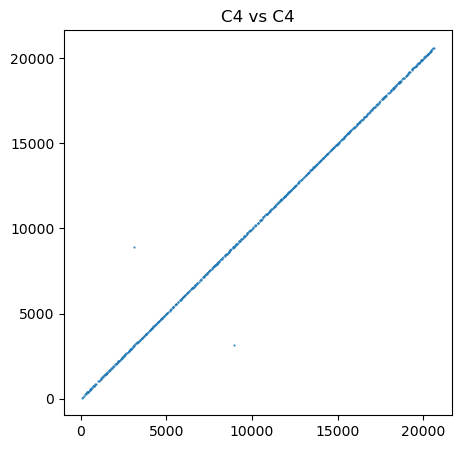

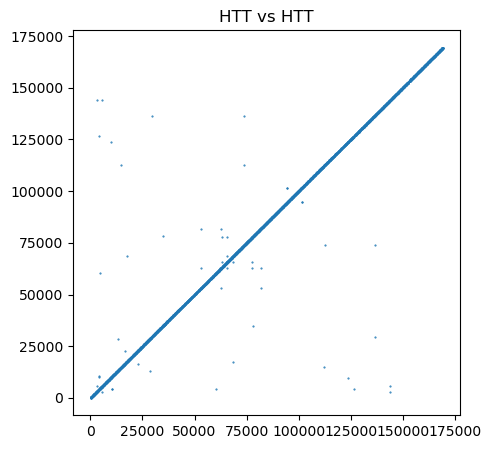

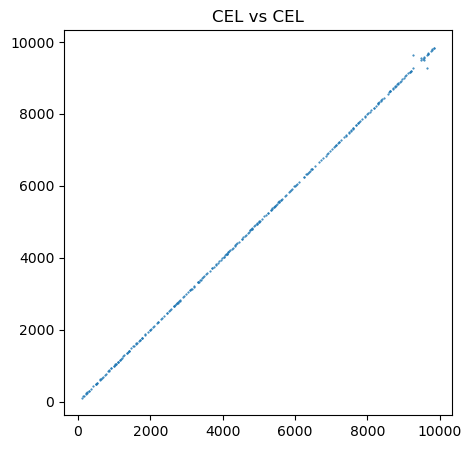

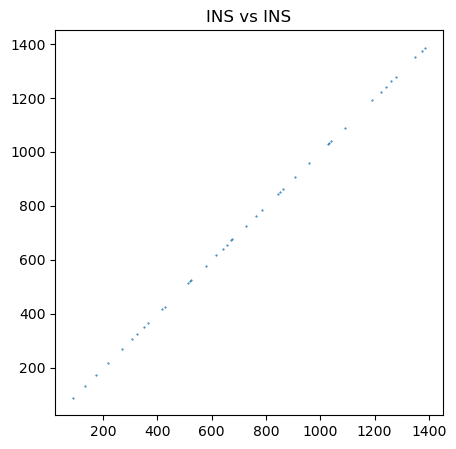

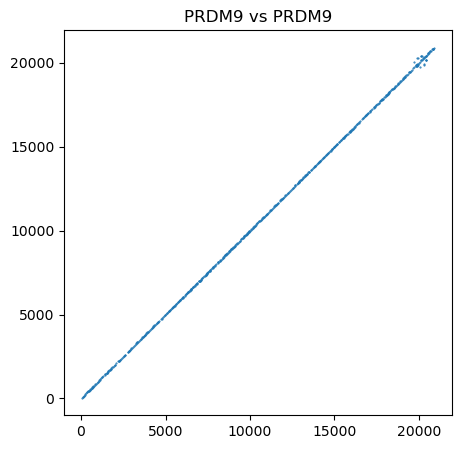

In [19]:
interesting_seqs = [C4_seq, HTT_seq, CEL_seq, INS_seq,PRDM9_seq]
seq_names = ["C4","HTT","CEL","INS","PRDM9"]
for seq, seq_name in zip(interesting_seqs, seq_names):
    plot_shimmer(seq, seq_name)

These have way less repeating regions than what I would expect. I likely made a mistake in finding the regions associated with each loci.

### Get hits from pangenome reference

In [70]:
C4_list = get_seq_list(C4_seq, plot=False)
HTT_list = get_seq_list(HTT_seq, plot=False)
CEL_list = get_seq_list(CEL_seq, plot=False)
INS_list = get_seq_list(INS_seq, plot=False)
PRDM9_list = get_seq_list(PRDM9_seq, plot=False)

### Build Subsets of Pangenome Graph

In [77]:
ROI_lists = [C4_list, HTT_list, CEL_list, INS_list, PRDM9_list]

for seq_name, ROI_list in zip(seq_names, ROI_lists):
    new_sdb = pgrtk.SeqIndexDB()
    new_sdb.load_from_seq_list(ROI_list, w=80, k=56, r=12, min_span=18)
    '''
    w: window size, 1 minimizer per window, increase to analyze larger structures more 
        efficiently. 
    k: minimizer size, (should stay smaller than window size)
    r: hierarchical reduction factor, 
    min_span: Minimum distance between minimizers.
    '''
    new_sdb.generate_mapg_gfa(0, f"data/region_graphs/{seq_name}.gfa")

# INS gfa file is empty despite having a seemingly normal input list. Not sure why.
# TODO

### Visualize Pangenome Graphs

In [86]:
%%bash
input="data/region_graphs/"
output="data/figures/"
for graph in $(ls data/region_graphs) ; do 
    image=${graph/".gfa"/".png"}
    echo "$output""$image"  
    Bandage image "$input""$graph" "$output""$image"  --edgewidth 1.0 --edgecol blue --colour random --outline 0.5 
    done

data/figures/C4.png
data/figures/CEL.png
data/figures/HTT.png
data/figures/INS.png



Bandage error: could not load data/region_graphs/INS.gfa


data/figures/PRDM9.png


C4 Locus

![C4_locus](data/figures/C4.png)

CEL Locus

![CEL_locus](data/figures/CEL.png)

HTT Locus

![HTT_locus](data/figures/HTT.png)

INS Locus

![INS_locus](data/figures/INS.png)

PRDM9 Locus

![PRDM9_locus](data/figures/PRDM9.png)